# Bayesian polynomial regression

This notebook will show different ways of doing polynomial regression.

The model is as follows: You have some set of inputs $x_1, \cdots, x_N$ where each element is a scalar. Now, let $\phi(x)$ be a  polynomial basis expansion that results in $D$ components (e.g. $\phi(x)=(0,x,x^2)$. Then the model is:

\begin{aligned}
w_i \sim & \mathrm{Normal}(0,.1) & 1 \leq i \leq D\\
σ^2 \sim & \mathrm{Exponential}(1) \\
y_n \sim & \mathrm{Normal}(w^\top \phi(x_n),\sigma^2) & 1 \leq n \leq N\\
\end{aligned}

Each of the code cells are self-contained, so they each have all the necessary import statements, etc.

## Method #1: all scalars, sample latent parameters

The simplest option is to do everything using scalars. Then, all the vector stuff is taken care of by Python (JAGS never sees a vector)

The typical thing that you'd do in most systems is sample the latent parameters, like below.

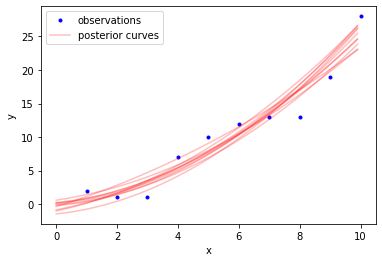

In [5]:
from pangolin import d, t, Given, sample
from matplotlib import pyplot as plt
import numpy as np

# training data
x_train = [1,2,3,4,5,6,7,8,9,10]
y_train = [2,1,1,7,10,12,13,13,19,28]

# model
w0 = d.norm(0,.10) # bias term
w1 = d.norm(0,.10) # linear term
w2 = d.norm(0,.10) # quadratic term
s  = d.exp(1) # noise variance

y = [d.norm(w0 + w1*xi + w2*xi**2,1/s) for xi in x_train]

# list of observations
observations = [yi==y_traini for (yi,y_traini) in zip(y,y_train)]

# inference
w0s,w1s,w2s,ss = sample([w0,w1,w2,s],Given(*observations))

# plot fits (ignores s, sadly)
plt.plot(x_train,y_train,'b.',label='observations')
label = 'posterior curves'
for w0,w1,w2 in zip(w0s[::100],w1s[::100],w2s[::100]):
    xrange = np.arange(0,10,.1)
    # manually predict curve from latent samples
    curve = w0+w1*xrange+w2*xrange**2
    plt.plot(xrange,curve,'r-',alpha=0.25,label=label)
    label=None # only label first
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

That's... OK. But it's not great. You have to manually manipulate the latent variables and make predictions for the test data with your bare hands, using a different language/syntax than you did for defining the posterior. It would be easy to make a mistake when manually creating the new curves. And this doesn't visualize the σ parameter.

Why? The point of Bayes is to let the math do the work for you, right? So let's just directly do inference over the test data.

## Method #2: all scalars, direct inference over test data


one option is to just draw samples for the test points and plot them


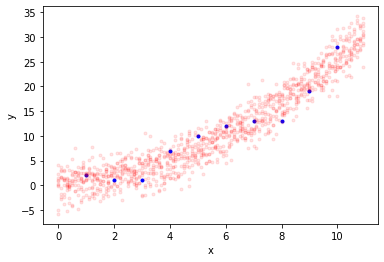

another is to plot the mean and std


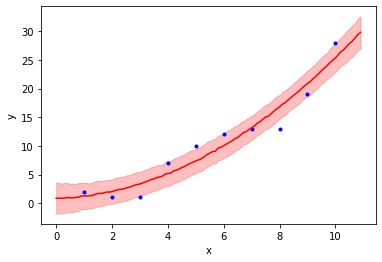

In [6]:
from pangolin import d, t, Given, E, sample, std, jags_code
from matplotlib import pyplot as plt
import numpy as np

# training data
x_train = [1,2,3,4,5,6,7,8,9,10]
y_train = [2,1,1,7,10,12,13,13,19,28]

# test data
x_test = np.arange(0,11,.1)

# model for training and test together
w0     = d.norm(0,.10) # bias term
w1     = d.norm(0,.10) # linear term
w2     = d.norm(0,.10) # quadratic term
s      = d.exp(1)      # noise variance
y      = [d.norm(w0 + w1*xi + w2*xi**2,1/s) for xi in x_train]
y_test = [d.norm(w0 + w1*xi + w2*xi**2,1/s) for xi in x_test]

# list of observations
observations = [yi==y_traini for (yi,y_traini) in zip(y,y_train)]

# plot
print('one option is to just draw samples for the test points and plot them')
y_pred = sample(y_test,Given(*observations))
plt.plot(x_train,y_train,'b.')
plt.plot(x_test,np.array(y_pred)[:,::100],'r.',alpha=0.1);
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print('another is to plot the mean and std')
y_pred_mean = np.array(E(y_test,Given(*observations)))
y_pred_std  = np.array(std(y_test,Given(*observations)))
y_lo = y_pred_mean - y_pred_std
y_hi = y_pred_mean + y_pred_std
plt.figure()
plt.plot(x_train,y_train,'b.')
plt.plot(x_test,y_pred_mean,'r-');
plt.fill_between(x_test,y_lo,y_hi,color='red',alpha=0.25);
plt.xlabel('x')
plt.ylabel('y');

This is nicer. But it's still pretty awkward to manipulate all the scalars by hand. Moreover, if you look at the JAGS code that is generated, all the loops are unrolled. This won't scale very well.

In [10]:
print(jags_code(y))

model{
v285v~dnorm(v283v,v284v);
v288v~dnorm(v286v,v287v);
v298v<-(v288v)*(v297v);
v299v<-(v285v)+(v298v);
v291v~dnorm(v289v,v290v);
v302v<-(v291v)*(v301v);
v303v<-(v299v)+(v302v);
v294v~dnorm(v292v,v293v);
v295v<-exp(v294v);
v306v<-(v305v)/(v295v);
v307v~dnorm(v303v,v306v);
v310v<-(v288v)*(v309v);
v311v<-(v285v)+(v310v);
v314v<-(v291v)*(v313v);
v315v<-(v311v)+(v314v);
v318v<-(v317v)/(v295v);
v319v~dnorm(v315v,v318v);
v322v<-(v288v)*(v321v);
v323v<-(v285v)+(v322v);
v326v<-(v291v)*(v325v);
v327v<-(v323v)+(v326v);
v330v<-(v329v)/(v295v);
v331v~dnorm(v327v,v330v);
v334v<-(v288v)*(v333v);
v335v<-(v285v)+(v334v);
v338v<-(v291v)*(v337v);
v339v<-(v335v)+(v338v);
v342v<-(v341v)/(v295v);
v343v~dnorm(v339v,v342v);
v346v<-(v288v)*(v345v);
v347v<-(v285v)+(v346v);
v350v<-(v291v)*(v349v);
v351v<-(v347v)+(v350v);
v354v<-(v353v)/(v295v);
v355v~dnorm(v351v,v354v);
v358v<-(v288v)*(v357v);
v359v<-(v285v)+(v358v);
v362v<-(v291v)*(v361v);
v363v<-(v359v)+(v362v);
v366v<-(v365v)/(v295v);
v367v~dnorm(v363v,v3

## Method #3: Array-valued random variables, direct inference over test data

If we're willing to use the primatives of `IID` and `vmap` then we can work with arrays, and do things in much more of a "numpy style".

For novelty, let's also use a higher-order polynomial.

draw samples for the test points and plot them


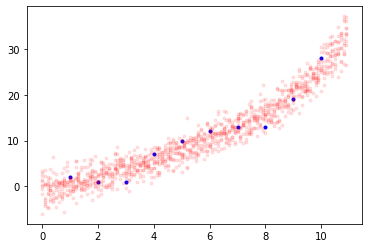

plot the mean and std


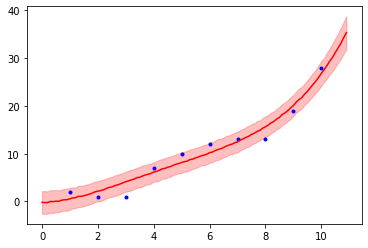

In [14]:
from pangolin import d, t, Given, IID, vmap, E, sample, std, jags_code
from matplotlib import pyplot as plt
import numpy as np

degree = 4

def φ(x):
    x = np.array(x)
    if x.ndim==1:
        x = np.array([x]).T
    x = np.hstack([x**p for p in range(degree+1)])
    return x

# training data
x_train = [1,2,3,4,5,6,7,8,9,10]
y_train = [2,1,1,7,10,12,13,13,19,28]

# test data
x_test = np.arange(0,11,.1)

# model
w = IID(d.norm(0,.10),degree+1) # all weights (using IID)
s = d.exp(1)                    # noise variance
def get_y(x):               # helper function
    mean = t.matmul(φ(x),w)
    return vmap(d.norm,[True,False])(mean,1/s)
y      = get_y(x_train)          # training outputs
y_test = get_y(x_test )      # test outputs

# get_y maps a set of inputs to a set of outputs

# inference (of samples)
y_pred = sample(y_test,Given(y==y_train))

# plot (samples)
print('draw samples for the test points and plot them')
plt.plot(x_train,y_train,'b.')
plt.plot(x_test,y_pred[::100,:].T,'r.',alpha=0.1);
plt.show()

# inference (of mean and std)
y_pred_mean = E(y_test,Given(y==y_train))
y_pred_std  = std(y_test,Given(y==y_train))

# plot (mean and std)
print('plot the mean and std')
y_lo = y_pred_mean - y_pred_std
y_hi = y_pred_mean + y_pred_std
plt.figure()
plt.plot(x_train,y_train,'b.')
plt.plot(x_test,y_pred_mean,'r-');
plt.fill_between(x_test,y_lo,y_hi,color='red',alpha=0.25);

Note that in `get_y` we had to call `t.matmul` instead of just using the infix operator. The reason is that `φ(x)` return a numpy array. So `φ(x) @ w` would be equivalent to `numpy.matmul(φ(x),w)` rather than the desired `t.matmul(φ(x),w)`. This wouldn't work because numpy doesn't know how to multiply Pangolin arrays.

If we look at the jags code this model generates, we can see that everything uses loops and vectorized operations. Things aren't unrolled.

In [16]:
print(jags_code(y))

model{
for (i0 in 1:5){
  v3521v[i0]~dnorm(v3518v,v3519v);
}
v3525v[1:10]<-(v3524v[1:10,1:5])%*%(v3521v[1:5]);
v3523v~dexp(v3522v);
v3528v<-(v3527v)/(v3523v);
for (i0 in 1:10){
  v3531v[i0]~dnorm(v3525v[i0],v3528v);
}
}

